In [11]:
import torch
import re

In [1]:
from wordcloud import WordCloud

In [20]:
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
import pyro

In [2]:
import string
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
from nltk.tokenize import word_tokenize
from gensim.utils import  simple_preprocess, tokenize
import nltk
import operator
import spacy
from nltk.corpus import stopwords
from collections import OrderedDict
from sklearn.decomposition import PCA, NMF, KernelPCA, LatentDirichletAllocation, TruncatedSVD, non_negative_factorization
from sklearn.cluster import DBSCAN, KMeans, kmeans_plusplus
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score, mutual_info_score
from sklearn.mixture import BayesianGaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%capture
from tqdm import tqdm

In [4]:
%config Completer.use_jedi = False

In [22]:
file_names = ['quit_my_job_100.csv', 'changing_careers_730.csv', 'changing_careers_100.csv', 'data_ruby_reddit.csv', 'jobhunt_nodups.csv', 'leavingmyjob_nodups.csv', 'newlyemployed_nodups.csv', 'data2_reddit.csv']

In [23]:
dataframes = []
for f in file_names:
    df = pd.read_csv(f)
    dataframes.append(df)
fdf = pd.concat(dataframes)

In [24]:
fdf.drop_duplicates(inplace=True)

In [25]:
len(fdf)

201119

In [27]:
fdf['text_length'] = fdf.body.apply(lambda x: len(x.split(" ")))

In [29]:
fdf = fdf[fdf["text_length"] > 10]
len(fdf)

196640

In [30]:
fdf.to_csv("Combined_reduced_dataset.csv")

In [38]:
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, TraceMeanField_ELBO

In [108]:
class TextEncoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, size_of_vocab, num_topics, hidden_layer, dropout):
        super().__init__() # Inherit from pytorch
        self.fully_connected_layer1, self.fully_connected_layer2 = nn.Linear(size_of_vocab, hidden_layer), nn.Linear(hidden_layer, hidden_layer)
        self.fully_connected_mean = nn.Linear(hidden_layer, num_topics)
        self.fully_connected_log_var = nn.Linear(hidden_layer, num_topics)
        self.dropout = nn.Dropout(dropout)  # to avoid component collapse
        # Set `affine=False` to reduce the number of learning params
        self.batch_norm_mean = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.batch_norm_log_var = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fully_connected_layer1(inputs)) # Feed inputs to first layer
        h = F.softplus(self.fully_connected_layer2(h)) # Feed to second layer
        h = self.dropout(h) # dropout
        # μ and Σ are the outputs
        log_theta_mean = self.batch_norm_mean(self.fully_connected_mean(h)) # batch normalization
        log_theta_log_var = self.batch_norm_log_var(self.fully_connected_log_var(h))
        log_theta_standardized = (0.5 * log_theta_log_var).exp() 
        return log_theta_mean, log_theta_standardized


class TextDecoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, size_of_vocab, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, size_of_vocab, bias=False)
        self.batch_norm = nn.BatchNorm1d(size_of_vocab, affine=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.dropout(inputs)
        # the output is σ(βθ)
        return F.softmax(self.batch_norm(self.beta(inputs)), dim=1)


class AEVITM(nn.Module):
    def __init__(self, size_of_vocab, num_topics, hidden_layer, dropout):
        super().__init__()
        self.size_of_vocab = size_of_vocab
        self.num_topics = num_topics
        self.encoder = TextEncoder(size_of_vocab, num_topics, hidden_layer, dropout)
        self.decoder = TextDecoder(size_of_vocab, num_topics, dropout)

    def decode(self, vectorized_text):
        pyro.module("decoder", self.decoder)
        with pyro.plate("text", vectorized_text.shape[0]):
            # Replace dirichlet prior distribution with a log normal distribution
            log_theta_mean, logtheta_standardized = vectorized_text.new_zeros((vectorized_text.shape[0], self.num_topics)), vectorized_text.new_ones((vectorized_text.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(log_theta_mean, logtheta_standardized).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(vectorized_text.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=vectorized_text
            )
    
    # This is an approximation of the posterior distribution
    def encode(self, vectorized_text):
        pyro.module("encoder", self.encoder)
        # instantiate plate as "text"
        with pyro.plate("text", vectorized_text.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            log_theta_mean, logtheta_standardized = self.encoder(vectorized_text)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(log_theta_mean, logtheta_standardized).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [31]:
import spacy
from spacy.cli import download

nlp = spacy.load("en_core_web_sm")

nlp.Defaults.stop_words |= {"people", "way", "get", "like", "thing", "quit", "job", "well", "tell", "lot", "hour"}

In [9]:
class TextPreProcessor:
    def __init__(self, data):
        self.text = data
        self.vocab = None
        self.doc_tokens = None
        self.tfidf = None
        self.cv = None
        self.is_cleaned = False
        self.is_normalized = False
        self.word_counts = None
        self.cleaned_text = None
        self.st_words = ["a", "an", "the", "yea", "yeah", "to", "\"", "just", "in", "of", "at", "her", "him", "his", "hers", "i", "me", "and", "you", "it", "for", "\'", "t", "m", "s", "he", "if", "ve", "she", "so", "on", "2", "hes" ,"na", "that", "\'", "my", "the", "is", "a"]

        
    def tokenize(self):
        self.doc_tokens = [simple_preprocess(doc) for doc in self.text]

        
    def junk_removal(self):
        for d in tqdm(self.doc_tokens):
            for w in d:
                if len(w)> 15 or len(w)<= 3 or w in self.st_words:
                    d.remove(w)
                    
                    
    def clean_text(self):
        # These parts of speech will provide the most information in terms of semantics
        allowed_pos_tags = ['NN', 'NNS', 'JJ', 'JJR', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBN', 'VBP']
        ner_label_to_remove = 'PERSON'
        cleaned = []
        nlp.Defaults.stop_words |= {"people", "way", "get", "like", "thing", "quit", "job", "well", "tell", "lot", "hour", "say"}
        for doc in tqdm(nlp.pipe(self.text, batch_size=32)):
            clean = " ".join([t.lemma_ for t in doc if not t.is_stop if not t.is_punct and t.ent_type_ != ner_label_to_remove and t.tag_ in allowed_pos_tags])
            cleaned.append(clean)
        self.cleaned_text = cleaned
    
    
    def word_count(self):
        counts = dict()
        for row in self.doc_tokens:
            for word in row:
                if word in counts:
                    counts[word] += 1
                else:
                    counts[word] = 1
        self.word_counts = {k: v for k, v in sorted(counts.items(), key=lambda x: x[1], reverse = True)}
        print(self.word_counts)
    
    def get_cleaned_word_frequencies(self):
        if self.is_normalized and self.is_cleaned:
            self.word_count()
            top_words_df = pd.DataFrame(list(self.word_counts))
            top_words_df = top_words_df.transpose()
            print(top_words_df)

        else:
            print("Normalize and/or clean the text")

    def create_vocab(self):
        if self.doc_tokens is not None:
            v_tokens = set()
            for doc_toks in self.doc_tokens:
                v_tokens|= set(doc_toks)
            self.vocab = v_tokens
        else:
            print("There are no tokens. Call the tokenize method on your data.")

    def remove_special_chars(self):
        if not self.is_cleaned :
            # Removing special chars using translate (This is a very fast/efficient way of doing this)
            table = str.maketrans('', '', string.punctuation)
            self.text = [t.translate(table) for t in self.text]
            self.is_cleaned = True
        else:
            print("Text is already cleaned.")

    def normalize_text(self):
        if not self.is_normalized:
            self.text = [doc.lower() for doc in self.text]
            self.text = [doc.strip("\n") for doc in self.text]
            self.text = [re.sub('\w*\d\w*', '', doc) for doc in self.text] # remove words containing numbers(new)
            self.text = [re.sub('[‘’“”…]', '', doc) for doc in self.text] # remove additional punctuation(new)
            self.text = [re.sub('\n', '', doc) for doc in self.text] # remove \n(new)
            self.clean_text()
            self.is_normalized = True
        else:
            print("Text is already normalized")

    def vectorize_tokens(self, vectorizer, min_df, max_df, ngram_range):
        if vectorizer =='tfidf':
            self.tfidf = TfidfVectorizer(stop_words = {'english'}, max_df = max_df, min_df = min_df, ngram_range=ngram_range)
            self.vectorized_text = self.tfidf.fit_transform(self.text)
        else:
            self.cv = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range)
            self.vectorized_text = self.cv.fit_transform(self.text)

In [72]:
# af = pd.read_csv("Combined_reduced_dataset.csv")
# af.body.dropna(inplace=True)

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [36]:
# text = af.body.tolist()
# allowed_pos_tags = ['NN', 'NNS', 'JJ', 'JJR', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBN', 'VBP']
# ner_label_to_remove = 'PERSON'
# cleaned = []
# nlp.Defaults.stop_words |= {"people", "way", "get", "like", "thing", "quit", "job", "well", "tell", "lot", "hour", "say"}
# for doc in tqdm(nlp.pipe(text, batch_size=32)):
#     clean = " ".join([t.lemma_ for t in doc if not t.is_stop if not t.is_punct and t.ent_type_ != ner_label_to_remove and t.tag_ in allowed_pos_tags])
#     cleaned.append(clean)
# af['body_cleaned'] = cleaned  

In [5]:
af = pd.read_csv("Reddit_data_cleaned.csv")

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
af['body_cleaned'] = af.body_cleaned.apply(str)

In [12]:
tpp = TextPreProcessor(af["body_cleaned"])

tpp.remove_special_chars()

tpp.normalize_text()

tpp.tokenize()

tpp.junk_removal()

NameError: name 'nlp' is not defined

In [95]:
len(af)

196644

In [16]:
# Instantiate Vectorizer object to vectorize the text, we can use count or tfidf
vectorizer = CountVectorizer(max_df=0.5, min_df=100, stop_words='english', ngram_range=(1,2))
texts = torch.from_numpy(vectorizer.fit_transform(af['body_cleaned']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

In [21]:
seed = 42
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = "cpu"

In [22]:
# pre-define number of topics to search for
num_topics = 20 

# Send the vectorized text to the cpu (good practice for pytorch)
texts = texts.float().to(device)

# Set batch size and learning rate, and number of training iterations
batch_size = 32
learning_rate = 1e-3
num_epochs = 25

In [109]:
ntm = AEVITM(
    size_of_vocab=texts.shape[1],
    num_topics=num_topics,
    hidden_layer= 10,
    dropout=0.15
)
ntm.to(device)

AEVITM(
  (encoder): TextEncoder(
    (fully_connected_layer1): Linear(in_features=15824, out_features=10, bias=True)
    (fully_connected_layer2): Linear(in_features=10, out_features=10, bias=True)
    (fully_connected_mean): Linear(in_features=10, out_features=20, bias=True)
    (fully_connected_log_var): Linear(in_features=10, out_features=20, bias=True)
    (dropout): Dropout(p=0.15, inplace=False)
    (batch_norm_mean): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (batch_norm_log_var): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (decoder): TextDecoder(
    (beta): Linear(in_features=20, out_features=15824, bias=False)
    (batch_norm): BatchNorm1d(15824, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (dropout): Dropout(p=0.15, inplace=False)
  )
)

In [110]:
# We use ADAM because it utilizes the 2nd moment of the gradients (the variance)
optimizer = pyro.optim.Adam({"lr": learning_rate})

# Stochastic Variational Inference
svi = SVI(ntm.decode, ntm.encode, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(texts.shape[0] / batch_size))

In [111]:
losses = []
iterations = list(range(num_epochs))
for e in range(num_epochs):
    print("Training Iteration " + str(e+1))
    running_loss = 0.0
    for i in tqdm(range(num_batches)):
        batch_texts = texts[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_texts)
        running_loss += loss / batch_texts.size(0)
        running_loss = round(running_loss, 2)
    print("Loss: " + str(running_loss))
    print("\n")
    losses.append(running_loss)

  0%|          | 1/6146 [00:00<13:13,  7.75it/s]

Training Iteration 1


  0%|          | 5/6146 [00:00<02:25, 42.06it/s]

Loss: 3123904.09
Training Iteration 2


  0%|          | 4/6146 [00:00<02:36, 39.21it/s]

Loss: 3122874.71
Training Iteration 3


  0%|          | 5/6146 [00:00<02:21, 43.29it/s]

Loss: 3123508.59
Training Iteration 4


  0%|          | 4/6146 [00:00<02:45, 37.18it/s]

Loss: 3123507.43
Training Iteration 5


  0%|          | 4/6146 [00:00<02:56, 34.78it/s]

Loss: 3123596.2
Training Iteration 6


  0%|          | 4/6146 [00:00<02:33, 39.94it/s]

Loss: 3123294.04
Training Iteration 7


  0%|          | 4/6146 [00:00<02:48, 36.41it/s]

Loss: 3123844.0
Training Iteration 8


  0%|          | 4/6146 [00:00<03:09, 32.44it/s]

Loss: 3123903.96
Training Iteration 9


  0%|          | 4/6146 [00:00<02:43, 37.61it/s]

Loss: 3123447.17
Training Iteration 10


  0%|          | 5/6146 [00:00<02:10, 46.96it/s]

Loss: 3122852.51
Training Iteration 11


  0%|          | 5/6146 [00:00<02:04, 49.42it/s]

Loss: 3123374.1
Training Iteration 12


  0%|          | 4/6146 [00:00<02:35, 39.45it/s]

Loss: 3123477.9
Training Iteration 13


  0%|          | 4/6146 [00:00<02:52, 35.62it/s]

Loss: 3123374.22
Training Iteration 14


  0%|          | 4/6146 [00:00<02:39, 38.60it/s]

Loss: 3123488.23
Training Iteration 15


  0%|          | 4/6146 [00:00<03:03, 33.45it/s]

Loss: 3122981.93
Training Iteration 16


  0%|          | 5/6146 [00:00<02:05, 48.75it/s]

Loss: 3123302.71
Training Iteration 17


  0%|          | 5/6146 [00:00<02:05, 48.79it/s]

Loss: 3123082.74
Training Iteration 18


  0%|          | 5/6146 [00:00<02:12, 46.21it/s]

Loss: 3123204.9
Training Iteration 19


  0%|          | 5/6146 [00:00<02:14, 45.78it/s]

Loss: 3122848.13
Training Iteration 20


  0%|          | 5/6146 [00:00<02:15, 45.48it/s]

Loss: 3124028.11
Training Iteration 21


  0%|          | 5/6146 [00:00<02:15, 45.45it/s]

Loss: 3123505.12
Training Iteration 22


  0%|          | 1/6146 [00:00<10:18,  9.94it/s]

Loss: 3123451.88
Training Iteration 23


  0%|          | 5/6146 [00:00<02:11, 46.79it/s]

Loss: 3124010.33
Training Iteration 24


  0%|          | 4/6146 [00:00<02:59, 34.15it/s]

Loss: 3124062.35
Training Iteration 25


100%|██████████| 6146/6146 [02:19<00:00, 44.00it/s]


Loss: 3124058.53


Text(0.5, 1.0, 'Loss per training iteration')

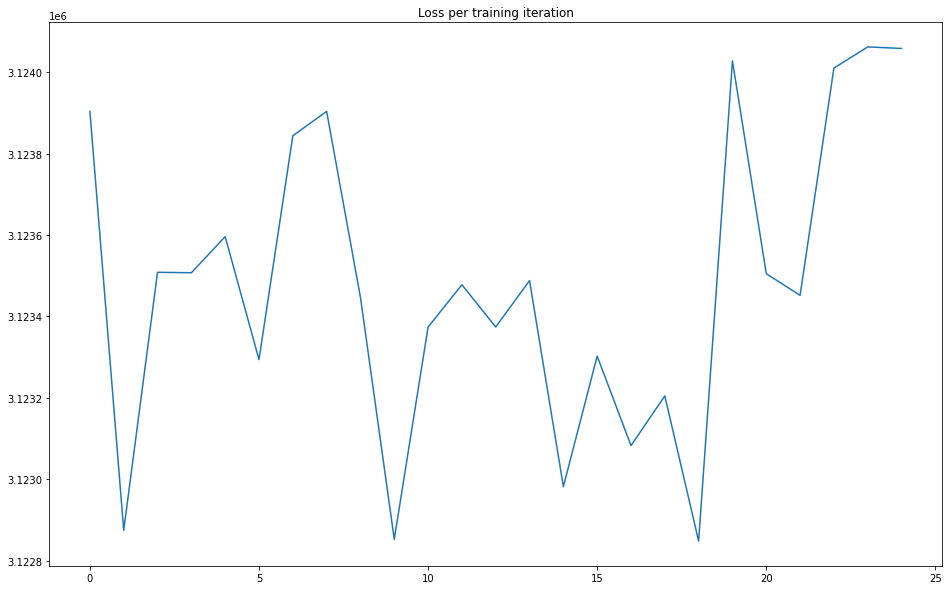

In [114]:
fig, ax = plt.subplots(figsize=(16,10))
plt.plot(iterations, losses)
ax.set_title("Loss per Training Iteration")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

In [69]:
from wordcloud import WordCloud

In [115]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="black", width=1000, height=800)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('AEVITM Topic %d' % (n + 1))
    
    # plot the wordcloud
    ax.imshow(wc, interpolation='bilinear')
    
    # Dont show the axis (makes the wordcloud cleaner)
    ax.axis("off")



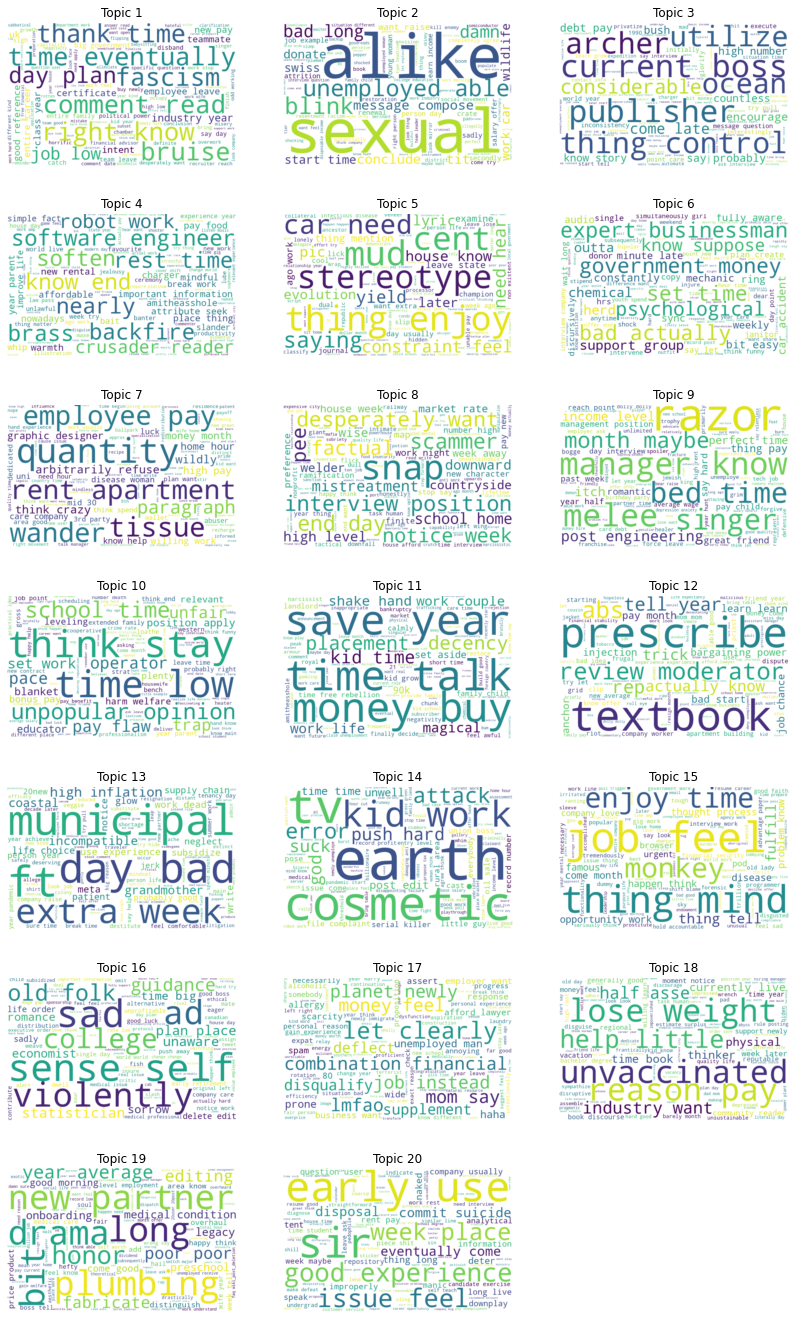

In [117]:
# if not smoke_test:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

ntm_weight = ntm.beta()
fig, ax = plt.subplots(7, 3, figsize=(14, 24))
for n in range(ntm_weight.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(ntm_weight[n], ax[i, j], vocab, n)
axs[-1, -1].axis('off');

plt.show()

# LDA

In [123]:
lda = LatentDirichletAllocation(20, learning_decay=0.75, max_iter=10, random_state=42, n_jobs=-1, verbose=-1)

In [124]:
lda.fit_transform(texts)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


array([[0.00263158, 0.00263158, 0.00263158, ..., 0.1193287 , 0.12228723,
        0.00263158],
       [0.00294118, 0.00294118, 0.00294118, ..., 0.00294118, 0.00294118,
        0.00294118],
       [0.08872931, 0.00142857, 0.00142857, ..., 0.00142857, 0.00142857,
        0.23933881],
       ...,
       [0.00294118, 0.4495633 , 0.00294118, ..., 0.00294118, 0.00294118,
        0.00294118],
       [0.00135135, 0.26733554, 0.00135135, ..., 0.00135135, 0.09447285,
        0.00135135],
       [0.00555556, 0.00555556, 0.00555556, ..., 0.00555556, 0.00555556,
        0.00555556]])

In [125]:
features = vectorizer.get_feature_names()

In [126]:
n_samples = 2000
n_features = 1000
n_components = 20
n_top_words = 15

In [13]:
def plot_top_words(model, feature_names, n_top_words, title, n_comps):
    rows = int(n_comps/5)
    fig, axes = plt.subplots(rows, 5, figsize=(16, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

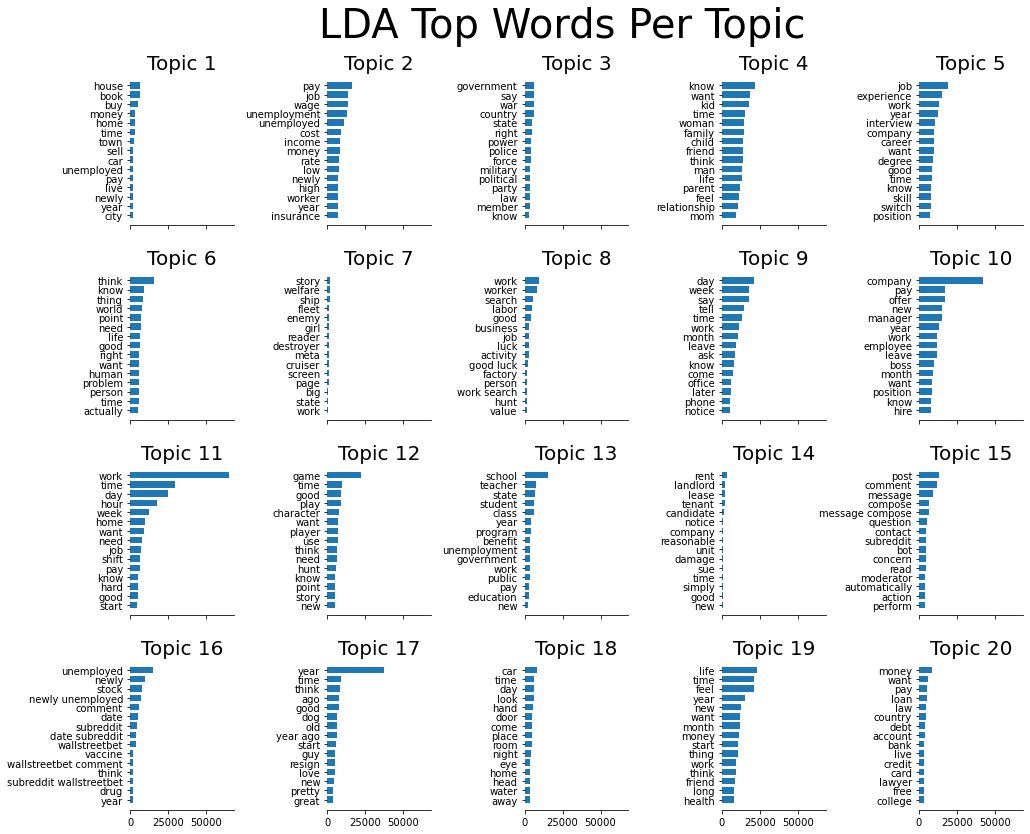

In [140]:
plot_top_words(lda, features, n_top_words, "LDA Top Words Per Topic", 20)

In [ ]:
from wordcloud import WordCloud

def show_subreddit_word_cloud(df, column_name):
    wordcloud = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)
    wordcloud.generate(' '.join(df[column_name]))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    return plt.show()

In [ ]:
class ModelData: 
    
    def __init__(self, data):
        self.data = data
        self.tpp = None
        
        
    def remove_bots(self):
        bots = pd.read_csv("bot_list_data.csv")
        df = self.data
        df_filtered = df[~df['author'].isin(bots['Username'])]
        self.data = df_filtered
        
        
    def process_data(self):
        tpp = TextPreProcessor(self.data)
        tpp.remove_special_chars()
        tpp.normalize_text()
        tpp.tokenize()
        tpp.create_vocab()
        tpp.get_cleaned_word_frequencies()
        tpp.vectorize_tokens()
        self.tpp = tpp
        
        
    def tokenize(text):
        tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
        tokens = map(str.lower, tokens)
        stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
        return stems
    
    
    def plot_top_words(self,model, feature_names, n_top_words, title,n_comps):
        rows = int(n_comps/5)
        fig, axes = plt.subplots(rows, 5, figsize=(30, 15), sharex=True)
        axes = axes.flatten()
        print(len(model.components_))
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=20)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)
        plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
        plt.show()
        
        
    def run_and_plot_LDA(self):
        lda = LatentDirichletAllocation(25, learning_decay=0.8, max_iter=15, random_state=42)
        # What exactly should we be passing below? Above, it's tpp.vectorized_text, 
        # but that value doesn't see to exist in the class?
        lda.fit_transform(self.tpp.vectorized_text) 
        features = self.tpp.tfidf.get_feature_names()

        n_samples = 2000
        n_features = 1000
        n_components = len(lda.components_)
        n_top_words = 20
        self.plot_top_words(lda, features, n_top_words, "LDA Top Words Per Topic", n_components)
        